# Проект 3. Исследование поведения пользователей в игре Quiz Freeze.
## Задачи:
##### 1. Определить, насколько обучение сокращает время прохождения этапов игры.	
##### 2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.	
##### 3. Определить, насколько прозрачен процесс взаимодействия с игрой.	

In [17]:
# Импортируем библиотеки, читаем файлы
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

events = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase = pd.read_csv('data/purchase.csv', sep=',')

In [18]:
# Выберем только данные по пользователям, которые зарегистрировались в 2018 году
mask1 = events['event_type'] == 'registration'
mask2 = ((events['start_time'] >= '2018-01-01') & (events['start_time'] < '2019-01-01'))
users_reg_18 = events[mask1 & mask2]['user_id'].to_list()

events_df = pd.DataFrame
events_df = events[events.user_id.isin(users_reg_18)]

# Изменим столбец со временем на формат datetime
events_df['start_time'] = pd.to_datetime(events_df['start_time'], format='%Y-%m-%dT%H:%M:%S')

# В датасете заказов тоже оставим только пользователей, пришедших в 2018 году, и изменим формат времени
purchase_df = pd.DataFrame
purchase_df = purchase[purchase['user_id'].isin(users_reg_18)]
purchase_df['event_datetime'] = pd.to_datetime(purchase_df['event_datetime'], format='%Y-%m-%dT%H:%M:%S')

Объединим два датафрейма

In [19]:
# Добавим в датафрейм purchase_df столбец event_type и присвоим всем строкам текст purchase
purchase_df['event_type'] = 'purchase'
# В двух датафреймах есть столбец id, но они разные - события и заказа. Поэтому переименуем их перед объединением таблиц
events_df = events_df.rename(columns={'id':'event_id'})
purchase_df = purchase_df.rename(columns={'id':'purchase_id'})
# Объединяем вниз два датафрейма
total_events_df = pd.concat([events_df, purchase_df], sort=False)
# Сбросим индексы объединённой таблицы, отсортируем события по возрастанию времени
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

### Гипотеза 1. 
### Определить, насколько обучение сокращает время прохождения этапов игры.

Для этого надо сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.

In [20]:
# Определим список пользователей, которые завершили обучение
users_finished_tutorial = total_events_df[
    total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique().tolist()
# Определим список пользователей, которые не начинали обучение. Для этого от множества всех прользователей отнимем тех,
# кто начал обучение
set_all_users = set(total_events_df['user_id'].unique())
users_started_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'].unique().tolist()
set_users_not_started_tutorial = set_all_users.difference(set(users_started_tutorial))

In [21]:
# Определим время между разными событиями у двух групп
# Создадим датафрейм регистриация, и выбор уровня, выбор пакета, покупка. Объединим их, посчитаем дельты времени,
# и отфильтруем по группам
registration_df = total_events_df[total_events_df['event_type'] == 'registration'][['user_id', 'start_time']]
registration_df = registration_df.rename(columns={'start_time': 'registration_time'})

level_choice_df = total_events_df[total_events_df['event_type'] == 'level_choice'][['user_id', 'start_time']]
level_choice_df = level_choice_df.rename(columns={'start_time': 'level_choice_time'})

pack_choice_df = total_events_df[total_events_df['event_type'] == 'pack_choice'][['user_id', 'start_time']]
pack_choice_df = pack_choice_df.rename(columns={'start_time': 'pack_choice_time'})

purchase_df_new = purchase_df[['user_id', 'event_datetime']].rename(columns={'event_datetime': 'purchase_time'})

# Объединяем таблицы регистрации и выбора уровня, считаем среднее время между событиями по группам
merged_reg_and_level_choice = registration_df.merge(level_choice_df, on='user_id')
merged_reg_and_level_choice['timedelta'] = \
    merged_reg_and_level_choice['level_choice_time'] - merged_reg_and_level_choice['registration_time']

# Узнаем среднее время между регистрацией и выбором уровня для двух групп: кто учился и кто - нет
reg_level_choice_td_finished_tutorial = \
    merged_reg_and_level_choice[merged_reg_and_level_choice['user_id'].isin(
        users_finished_tutorial)]['timedelta'].mean()
print('Среднее время между регистрацией и выбором уровня сложности для пользователей, завершивших обучение: ',
      reg_level_choice_td_finished_tutorial)

reg_level_choice_td_not_started_tutorial = \
    merged_reg_and_level_choice[merged_reg_and_level_choice['user_id'].isin(
        set_users_not_started_tutorial)]['timedelta'].mean()
print('Среднее время между регистрацией и выбором уровня сложности для пользователей, не начинавших обучение: ',
      reg_level_choice_td_not_started_tutorial)

Среднее время между регистрацией и выбором уровня сложности для пользователей, завершивших обучение:  0 days 07:05:36.854819357
Среднее время между регистрацией и выбором уровня сложности для пользователей, не начинавших обучение:  0 days 05:15:33.122448979


In [22]:
# Объединяем таблицы выбора уровня и выбора пакета, считаем среднее время между событиями по группам
merged_level_and_pack_choice = level_choice_df.merge(pack_choice_df, on='user_id')
merged_level_and_pack_choice['timedelta'] = \
    merged_level_and_pack_choice['pack_choice_time'] - merged_level_and_pack_choice['level_choice_time']

# Узнаем среднее время между выбором уровня и выбором пакета для двух групп: кто учился и кто - нет
level_and_pack_choice_td_finished_tutorial = \
    merged_level_and_pack_choice[merged_level_and_pack_choice['user_id'].isin(
        users_finished_tutorial)]['timedelta'].mean()
print('Среднее время между выбором уровня сложности и выбором пакета для пользователей, завершивших обучение: ',
      level_and_pack_choice_td_finished_tutorial)

level_and_pack_choice_td_not_started_tutorial = \
    merged_level_and_pack_choice[merged_level_and_pack_choice['user_id'].isin(
        set_users_not_started_tutorial)]['timedelta'].mean()
print('Среднее время между выбором уровня сложности и выбором пакета для пользователей, не начинавших обучение: ',
      level_and_pack_choice_td_not_started_tutorial)

Среднее время между выбором уровня сложности и выбором пакета для пользователей, завершивших обучение:  0 days 00:05:18.146058732
Среднее время между выбором уровня сложности и выбором пакета для пользователей, не начинавших обучение:  0 days 00:05:23.824324324


In [23]:
# Объединяем таблицы выбора пакета и покупки, считаем среднее время между событиями по группам
merged_pack_choice_and_purchase = pack_choice_df.merge(purchase_df_new, on='user_id')
merged_pack_choice_and_purchase['timedelta'] = \
    merged_pack_choice_and_purchase['purchase_time'] - merged_pack_choice_and_purchase['pack_choice_time']

# Узнаем среднее время между выбором пакета и покупкой для двух групп: кто учился и кто - нет
pack_choice_and_purchase_td_finished_tutorial = \
    merged_pack_choice_and_purchase[merged_pack_choice_and_purchase['user_id'].isin(
        users_finished_tutorial)]['timedelta'].mean()
print('Среднее время между выбором пакета и покупкой для пользователей, завершивших обучение: ',
      pack_choice_and_purchase_td_finished_tutorial)

pack_choice_and_purchase_td_not_started_tutorial = \
    merged_pack_choice_and_purchase[merged_pack_choice_and_purchase['user_id'].isin(
        set_users_not_started_tutorial)]['timedelta'].mean()
print('Среднее время между выбором пакета и покупкой для пользователей, не начинавших обучение: ',
      pack_choice_and_purchase_td_not_started_tutorial)

Среднее время между выбором пакета и покупкой для пользователей, завершивших обучение:  3 days 17:17:59.641326883
Среднее время между выбором пакета и покупкой для пользователей, не начинавших обучение:  4 days 04:49:33.590909090


In [24]:
# Построим датафрейм для дальнейшего построения столбчатой диаграммы. Время переведём в минуты, чтобы можно было сравнить в диаграмме
level_times_df = pd.DataFrame([[round(reg_level_choice_td_finished_tutorial.total_seconds()/60, 2),
                                round(level_and_pack_choice_td_finished_tutorial.total_seconds()/60, 2),
                                 round(pack_choice_and_purchase_td_finished_tutorial.total_seconds()/60, 2)],
                                [round(reg_level_choice_td_not_started_tutorial.total_seconds()/60, 2),
                                 round(level_and_pack_choice_td_not_started_tutorial.total_seconds()/60, 2),
                                 round(pack_choice_and_purchase_td_not_started_tutorial.total_seconds()/60, 2)]],
                              index=['finished_tutorial', 'not_started_tutorial'],
                              columns=['td_reg_and_level_choice', 'td_level_and_pack_choice',
                                       'td_pack_choice_and_purchase'])
display(level_times_df)

,td_reg_and_level_choice,td_level_and_pack_choice,td_pack_choice_and_purchase
finished_tutorial,425.61,5.3,5357.99
not_started_tutorial,315.55,5.4,6049.56


### Гипотеза 2. 
### Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Для этого надо проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

Разделим пользователей на группы, кто не начинал обучение, и начинал по количеству раз

In [25]:
# Определим список пользователей, которые начинали обучение, посчитаем кто по сколько раз начинал
users_started_tutorial_df = \
    total_events_df[total_events_df['event_type'] == 'tutorial_start'][['user_id', 'start_time']]
users_with_times_started_tutorial = users_started_tutorial_df.groupby('user_id',as_index = False).count()
# Добавим к ним тех, кто не начинал обучение, с отметкой ноль
not_started_df = pd.DataFrame({'user_id': list(set_users_not_started_tutorial)})
not_started_df['start_time'] = 0
# Объединим их
total_start_tutorial_df = pd.concat([users_with_times_started_tutorial,not_started_df],sort=False)
# Получилась таблица, в которой указаны пользователи с количеством раз, сколько они начинали обучение
# Посчитаем количество покупок на каждого пользователя
purchase_count = purchase_df_new.groupby('user_id', as_index=False).count()
# Присоединим таблицу с количеством заказов к таблице с количеством стартов обучений, заменим отсутствие заказов нулями
start_tutorial_and_purchase = total_start_tutorial_df.merge(purchase_count, on='user_id', how='left').fillna(0)

Разделим пользователей на группы, кто не заканчивал обучение, и заканчивал по количеству раз

In [26]:
# Определим список пользователей, которые окрнчили обучение, посчитаем кто по сколько раз окончил
users_finished_tutorial_df = \
    total_events_df[total_events_df['event_type'] == 'tutorial_finish'][['user_id', 'start_time']]
users_with_times_finish_tutorial = users_finished_tutorial_df.groupby('user_id',as_index = False).count()
# Добавим к ним тех, кто не начинал обучение, с отметкой ноль
set_users_not_finished_tutorial = set_all_users.difference(set(users_finished_tutorial_df['user_id']))
not_finished_df = pd.DataFrame({'user_id': list(set_users_not_finished_tutorial)})
not_finished_df['start_time'] = 0
# Объединим их
total_finish_tutorial_df = pd.concat([users_with_times_finish_tutorial,not_finished_df],sort=False)
# Получилась таблица, в которой указаны пользователи с количеством раз, сколько они оканчивали обучение
# Присоединим таблицу с количеством заказов к таблице с количеством окончаний обучений, заменим NaN нулями
finish_tutorial_and_purchase = total_finish_tutorial_df.merge(purchase_count, on='user_id', how='left').fillna(0)

Посчитаем среднее количество заказов на пользователей разных групп, для дальнейшего построения диаграммы на основе датафреймов

In [27]:
# Считаем среднее количество заказов на пользователя, согласно его группе количества стартов обучения
grouped_start_tutorial_and_purchase = \
    start_tutorial_and_purchase.groupby('start_time', as_index=False)['purchase_time'].mean()
display(grouped_start_tutorial_and_purchase)

# Считаем среднее количество заказов на пользователя, согласно его группе количества окончаний обучения
grouped_finish_tutorial_and_purchase = \
    finish_tutorial_and_purchase.groupby('start_time', as_index=False)['purchase_time'].mean()
display(grouped_finish_tutorial_and_purchase)

,start_time,purchase_time
0,0,0.002727
1,1,0.132594
2,2,0.137193
3,3,0.119438
4,4,0.135747
5,5,0.146789
6,6,0.120690
7,7,0.127660
8,8,0.151163
9,9,0.150442


,start_time,purchase_time
0,0,0.015812
1,1,0.142608
2,2,0.137774
3,3,0.127536
4,4,0.106742
5,5,0.162393
6,6,0.148515
7,7,0.154639
8,8,0.111111
9,9,0.181818


### Гипотеза 3. 
### Определить, насколько прозрачен процесс взаимодействия с игрой.

Надо выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

In [28]:
# Создадим датафрейм с событием старта обучения, сравним время с событием выбора уровня сложности
tutorial_start_df = total_events_df[total_events_df['event_type'] == 'tutorial_start'][['user_id', 'start_time']]
tutorial_start_df = tutorial_start_df.rename(columns={'start_time': 'tutorial_start_time'})
# Объединим датафреймы и сравним время начала обучения и время выбора уровня сложности по каждой строке начала обучения
merged_hypothesis_3 = tutorial_start_df.merge(level_choice_df, on='user_id', how='left')
merged_hypothesis_3['late_tutorial'] = merged_hypothesis_3['level_choice_time'] < \
                                       merged_hypothesis_3['tutorial_start_time']
# Считаем количество поздних обучений, и считаем их процент от выбора уровня сложности
late_tutorial_percent = (merged_hypothesis_3[merged_hypothesis_3['late_tutorial'] == True]['user_id'].count() /
                         tutorial_start_df['user_id'].count())*100
print('Процент случаев, в котором пользователи возвращаются к обучению '
      'после выбора уровня сложности: ', round(late_tutorial_percent, 2))

Процент случаев, в котором пользователи возвращаются к обучению после выбора уровня сложности:  15.47


#### Строим диаграммы.

Сначала импортируем библиотеку matplotlib, затем построим 3 столбчатых диаграммы для каждого из временных промежутков между событиями, для проверки первой гипотезы.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

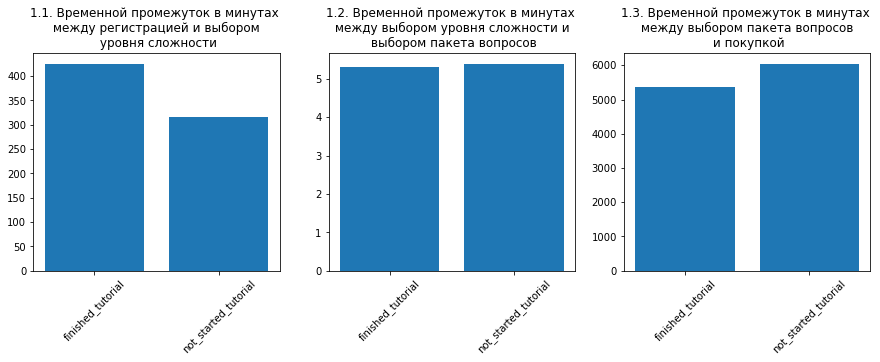

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes[0].bar(
    x=level_times_df.index,
    height=level_times_df['td_reg_and_level_choice'],
    label='минут'
)
axes[0].set_title('1.1. Временной промежуток в минутах \n между регистрацией и выбором \n уровня сложности')
axes[0].xaxis.set_tick_params(rotation=45)

axes[1].bar(
    x=level_times_df.index,
    height=level_times_df['td_level_and_pack_choice']
)
axes[1].set_title('1.2. Временной промежуток в минутах \n между выбором уровня сложности и \n выбором пакета вопросов')
axes[1].xaxis.set_tick_params(rotation=45)

axes[2].bar(
    x=level_times_df.index,
    height=level_times_df['td_pack_choice_and_purchase']
)
axes[2].set_title('1.3. Временной промежуток в минутах \n между выбором пакета вопросов \n и покупкой')
axes[2].xaxis.set_tick_params(rotation=45)

Построим 2 столбчатые диаграммы чтобы увидеть наглядно, есть ли зависимость вероятности покупки от количеств стартов и окончаний обучений.

<AxesSubplot:title={'center':'2.1. Среднее количество покупок на пользователя \n в зависимости от количества стартов обучения'}, xlabel='количество стартов обучения'>

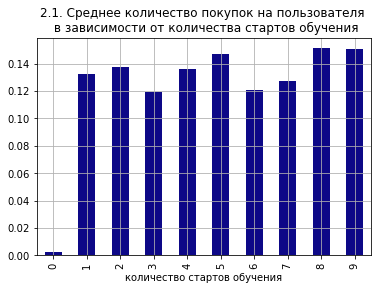

In [31]:
grouped_start_tutorial_and_purchase.plot(
    kind='bar',
    x='start_time',
    legend = False,
    title = '2.1. Среднее количество покупок на пользователя \n в зависимости от количества стартов обучения',
    grid=True,
    colormap='plasma',
    xlabel='количество стартов обучения'
)

<AxesSubplot:title={'center':'2.2. Среднее количество покупок на пользователя \n в зависимости от количества завершений обучения'}, xlabel='количество завершений обучения'>

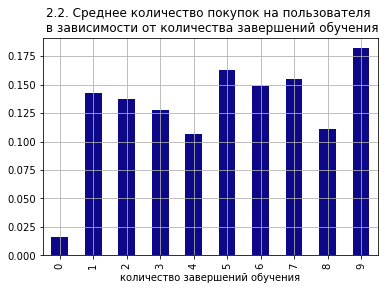

In [32]:
grouped_finish_tutorial_and_purchase.plot(
    kind='bar',
    x='start_time',
    legend = False,
    title = '2.2. Среднее количество покупок на пользователя \n в зависимости от количества завершений обучения',
    grid=True,
    colormap='plasma',
    xlabel='количество завершений обучения'
)

# Выводы.

#### Гипотеза 1. 
Как видно из диаграмм 1.1., 1.2. и 1.3., не находится явной зависимости скорости прохождения этапов от наличия оконченного обучения. Но видно, что пользователи, которые не обучаются, быстрее переходят от регистрации к выбору уровня сложности. Это можно объяснить тем, чтоб обучающиеся пользователи тратят время на обучение. Зато они немного быстрее переходят к покупке платных вопросов после выбора пакета бесплатных вопросов. Поэтому можно сделать вывод, что обучение незначительно сокращает время от выбора пакета вопросов до покупки. 
##### Гипотеза подтверждена частично.


#### Гипотеза 2. 
Диаграммы 2.1. и 2.2. показывают зависимость покупки от количества стартов и окончаний обучения. Видна значительная разница между обучавшимися и не обучавшимися пользователями - у обучающихся среднее количество покупок гораздо выше.
Таже прослеживается небольшая тенденция к росту вероятности покупки в зависимости от количества обучений, но она нестабильна и не явно выражена, поэтому считаю, что она требует дополнительных наблюдений.
##### Гипотеза подтверждена, т.к. успешное обучения явно влияет на вероятность покупки.


#### Гипотеза 3. 
Анализ данных показал, что процент случаев, в котором пользователи возвращаются к обучению после выбора уровня сложности:  15.47. Значит, некоторые пользователи всё же возвращаются к обучению, уже после старта игры. 
##### Можно говорить о том, что процесс взаимодействия с игрой недостаточно прозрачен.
